# Линейная регрессия

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

df = pd.read_csv('../content/sample_data/lin_reg.txt', header=None)
df.rename(
    columns={
        0: 'x1',
        1: 'x2',
        2: 'x3',
        3: 'x4',
        4: 'y',
    }, 
    inplace=True
)

X = df[['x1', 'x2', 'x3', 'x4']].values
Y = df[['y']].values

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [57]:
def forward_pass(w, X):
    b = w[0] * np.ones((X.shape[0], 1))
    w = w[1:]
    assert w.shape[0] == X.shape[1]
    assert b.shape[0] == X.shape[0]
    return  (X @ w).reshape(-1, 1) + b.reshape(-1, 1)

def func(w, X, Y, a=0):
    return np.sum(np.power(forward_pass(w, X) - Y, 2)) / len(Y) + a * (np.sum(np.power(w, 2)))

def train_test_split(X, train_size=0.8):
    n = X.shape[0]
    pivot = int(n * train_size)
    return X[:pivot], X[pivot:]

def train_test_split_df(df):
    train, test = train_test_split(df)
    X_train = train[['x1', 'x2', 'x3', 'x4']].values
    X_test = test[['x1', 'x2', 'x3', 'x4']].values
    Y_train = train[['y']].values
    Y_test = test[['y']].values
    return X_train, X_test, Y_train, Y_test

def fit_linear(X, Y, a=0, plot=False):
    history = {'w': [], 'error': []}

    def callback(w):
        history['w'].append(w)
        history['error'].append(J(w, X, Y))
    
    optimal_w = minimize(J, x0=np.zeros((X.shape[1] + 1, 1)), args=(X, Y, a), callback=callback, method='BFGS').x

    if plot:
        plot_learning_curve(history)
    return optimal_w, history

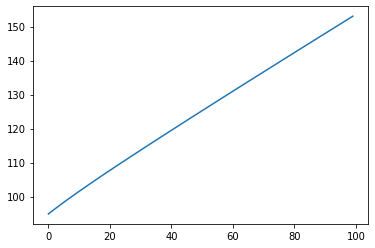

In [65]:
## График зависимости среднеквадратичной ошибки

errors = []
for a in np.linspace(0, 1, 100):
    w_optimal, _ = fit_linear(X, Y, a=a)
    error = J(w_optimal, X, Y, a=a)
    errors.append(error)
    
plt.plot(errors)

In [59]:
## Кросс-валидация

def cross_validation(df, cv=5, a=0):
    shuffled_df = df.sample(frac=1)
    n = len(shuffled_df)
    step = n // cv
    
    record = {
        'train_error': [],
        'test_error': []
    }
    for i in range(0, n, step):
        fold = shuffled_df[i:i + step]
        X_train, X_test, Y_train, Y_test = train_test_split_df(fold)
        w_optimal, _ = fit_linear(X_train, Y_train, a=a)
        record['train_error'].append(func(w_optimal, X_train, Y_train))
        record['test_error'].append(func(w_optimal, X_test, Y_test))
    return record

def mean_cv_record(record):
    return np.array(record['test_error']).mean()

In [67]:
## Оптимальное значение α

mean_errors = {}
for a_temp in np.linspace(0, 1, 90):
    record_cv = cross_validation(df, a=a_temp)  
    mean_errors[a_temp] = mean_cv_record(record_cv)
min_val = sorted(mean_errors.items(), key=lambda x: x[1])[0]
optimal_a = min_val[0]
print('оптимальное alpha', min_val[0], 'при MSE', min_val[1])

оптимальное alpha 0.898876404494382 при MSE 81.8449360651244


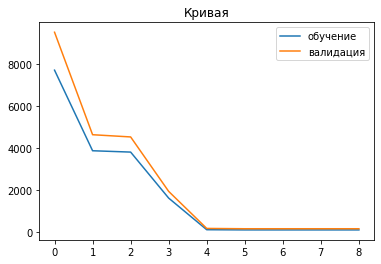

In [68]:
## Кривая валидации и обучения

def plot_learning_curve(record, X_test, Y_test, optimal_a):
    val_score = []
    for w in record['w']:
        val_score.append(func(w, X_test, Y_test, a=optimal_a))
    
    plt.figure()
    
    plt.plot(record['error'])
    plt.plot(val_score)
    
    plt.legend(['обучение', 'валидация'])
    plt.title('Кривая')

X_train, X_test, Y_train, Y_test = train_test_split_df(df)
w, history = fit_linear(X_train, Y_train, a=optimal_a)
plot_learning_curve(history, X_test, Y_test, optimal_a)